# Data Preparation

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
df = pd.read_parquet('s29.parquet')
df.head(1000000)

Time   Voltage   Current  Temperature
0      2019-04-17 20:55:21.870000  4.177705 -0.107940      26.9375
1      2019-04-17 20:55:22.910000  4.149615 -1.018332      27.0000
2      2019-04-17 20:55:23.140000  4.148885 -1.021173      27.0000
3      2019-04-17 20:55:23.890000  4.147791 -1.018332      27.0000
4      2019-04-17 20:55:24.880000  4.145967 -1.019753      27.0000
...                           ...       ...       ...          ...
27151  2019-04-18 03:55:42.940000  4.198243  0.069583      27.0625
27152  2019-04-18 03:55:43.800000  4.197879  0.071003      27.0625
27153  2019-04-18 03:55:43.940000  4.197514  0.071003      27.0625
27154  2019-04-18 03:55:44.940000  4.198243  0.071003      27.0625
27155  2019-04-18 03:55:45.930000  4.197879  0.071003      27.0000

[27156 rows x 4 columns]

In [98]:
df.drop(df[df['Voltage'] <= 2.65].index, inplace=True)
df.drop(df[df['Voltage'] >= 4.2].index, inplace=True)

In [99]:
result = df.loc[df['Current'] == 0]
print(result)

                             Time   Voltage  Current  Temperature
12832  2019-04-18 00:09:45.510000  2.650282      0.0      27.3750
12833  2019-04-18 00:09:53.200000  2.742283      0.0      27.3750
12834  2019-04-18 00:09:55.550000  2.749944      0.0      27.3750
12835  2019-04-18 00:10:03.230000  2.767820      0.0      27.3750
12836  2019-04-18 00:10:05.520000  2.771833      0.0      27.3750
...                           ...       ...      ...          ...
12961  2019-04-18 00:20:45.670000  2.888208      0.0      27.0625
12962  2019-04-18 00:20:45.750000  2.888208      0.0      27.0000
12963  2019-04-18 00:20:46.770000  2.888572      0.0      27.0000
12964  2019-04-18 00:20:46.790000  2.888572      0.0      27.0000
12965  2019-04-18 00:20:47.080000  2.888937      0.0      27.0000

[134 rows x 4 columns]


In [100]:
df[['Time', 'Voltage', 'Current', 'Temperature']][12830:12967]

Time   Voltage   Current  Temperature
12830  2019-04-18 00:09:44.880000  2.650646 -1.019753       27.375
12831  2019-04-18 00:09:45.420000  2.650282 -1.014071       27.375
12832  2019-04-18 00:09:45.510000  2.650282  0.000000       27.375
12833  2019-04-18 00:09:53.200000  2.742283  0.000000       27.375
12834  2019-04-18 00:09:55.550000  2.749944  0.000000       27.375
...                           ...       ...       ...          ...
12962  2019-04-18 00:20:45.750000  2.888208  0.000000       27.000
12963  2019-04-18 00:20:46.770000  2.888572  0.000000       27.000
12964  2019-04-18 00:20:46.790000  2.888572  0.000000       27.000
12965  2019-04-18 00:20:47.080000  2.888937  0.000000       27.000
12966  2019-04-18 00:20:48.090000  2.934174  1.018189       27.000

[137 rows x 4 columns]

In [14]:
# tegangan maksimum
print('V.Discharge :', df['Voltage'][13215])
print('V.charge :', df['Voltage'][13351])
print('V.restdischarge :', df['Voltage'][13217])
print('V.restcharge :', df['Voltage'][13350])
print('I.Discharge :', df['Current'][13215])
print('I.charge :', df['Current'][13351])

V.Discharge : 2.64998164115241
V.charge : 2.86981644795742
V.restdischarge : 2.64998164115241
V.restcharge : 2.86470936390106
I.Discharge : -1.02007534005679
I.charge : 0.163046817295253


In [491]:
# Training
# # Memanggil data
df = pd.read_parquet('s2.parquet')

# Penambahan Cycle
df['Cycle'] = 2

# Penambahan dTime
import pandas as pd

# ubah kolom waktu menjadi tipe datetime
df['Time'] = pd.to_datetime(df['Time'])

# hitung selisih waktu dari waktu awal
df['Time (s)'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

# selisih waktu
df['dTime'] = df['Time (s)'][0]

for i in range(1, len(df)):
    df.loc[i, 'dTime'] = abs(df.loc[i, 'Time (s)'] - df.loc[i-1, 'Time (s)'])

# Kapasitas yang berkurang tiap detik
df['dCapacity_a'] = df['Current']*df['dTime']/3600

# Akumulasi kapasitas berkurang pada waktu ke-n
df['dCapacity_b'] = df['dCapacity_a'][0]

for i in range(1, len(df)):
    df.loc[i, 'dCapacity_b'] = df.loc[i-1, 'dCapacity_b'] + df.loc[i, 'dCapacity_a']

# Selisih tegangan
df = df.assign(Vb=df['Voltage'].shift(1))
df = df.assign(deltaV=abs(df['Voltage'] - df['Vb']))
del df['Vb']
df['deltaV'][0] = 0

# Nilai OCV
Ri_chg = 0.035
Ri_dschg = 0.035

def calc_ocv(row):
    if row['Current'] < 0:
        return row['Voltage'] + row['Current']*Ri_dschg
    else:
        return row['Voltage'] + row['Current']*Ri_chg

df['OCV'] = df.apply(calc_ocv, axis=1)

# Mencari nilai DOD
df['DOD'] = abs((df['dCapacity_b']*-1/3.4)*100)

# Mencari nilai SOC
df['SOCref'] = (3.4+df['dCapacity_b'])/3.4*100

# Energi yang bertambah tiap detik
df['dEnergy'] = (df['Voltage']*df['Current']*df['dTime']/3600)

# Akumulasi energi bertambah pada waktu ke-n
df['Energy (Wh)'] = df['dEnergy'][0]

for i in range(1, len(df)):
    df.loc[i, 'Energy (Wh)'] = df.loc[i-1, 'Energy (Wh)'] + df.loc[i, 'dEnergy']

# Pengurutan Kolom
df = df[['Cycle', 'Time', 'Time (s)', 'dTime', 'Voltage', 'Current', 'Temperature', 'dCapacity_a', 'dCapacity_b', 'deltaV', 'DOD', 'SOCref', 'OCV', 'dEnergy', 'Energy (Wh)']]

df.head(100000)

C:\Users\wilyf\AppData\Local\Temp\ipykernel_16276\2572559078.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltaV'][0] = 0


Cycle                    Time  Time (s)  dTime   Voltage   Current   
0          1 2018-09-05 20:09:33.660      0.00   0.00  4.174988 -0.192759  \
1          1 2018-09-05 20:09:34.700      1.04   1.04  4.149462 -1.018668   
2          1 2018-09-05 20:09:35.670      2.01   0.97  4.147639 -1.022889   
3          1 2018-09-05 20:09:36.690      3.03   1.02  4.145816 -1.020075   
4          1 2018-09-05 20:09:37.680      4.02   0.99  4.145451 -1.020075   
...      ...                     ...       ...    ...       ...       ...   
27837      1 2018-09-06 03:22:46.160  25992.50   0.98  4.198023  0.071684   
27838      1 2018-09-06 03:22:47.170  25993.51   1.01  4.197658  0.068873   
27839      1 2018-09-06 03:22:48.170  25994.51   1.00  4.197658  0.068873   
27840      1 2018-09-06 03:22:49.170  25995.51   1.00  4.198023  0.068873   
27841      1 2018-09-06 03:22:49.710  25996.05   0.54  4.197658  0.067468   

       Temperature  dCapacity_a  dCapacity_b    deltaV       DOD      SOCref   
0           27.000    -0.000000    -0.000000  0.000000  0.000000  100.000000  \
1           27.000    -0.000294    -0.000294  0.025526  0.008655   99.991345   
2           27.000    -0.000276    -0.000570  0.001823  0.016762   99.983238   
3           27.000    -0.000289    -0.000859  0.001823  0.025262   99.974738   
4           27.000    -0.000281    -0.001139  0.000365  0.033513   99.966487   
...            ...          ...          ...       ...       ...         ...   
27837       27.125     0.000020    -0.008494  0.000365  0.249836   99.750164   
27838       27.125     0.000019    -0.008475  0.000365  0.249268   99.750732   
27839       27.125     0.000019    -0.008456  0.000000  0.248705   99.751295   
27840       27.125     0.000019    -0.008437  0.000365  0.248142   99.751858   
27841       27.125     0.000010    -0.008427  0.000365  0.247845   99.752155   

            OCV   dEnergy  Energy (Wh)  
0      4.168242 -0.000000    -0.000000  
1      4.113809 -0.001221    -0.001221  
2      4.111838 -0.001143    -0.002364  
3      4.110113 -0.001198    -0.003562  
4      4.109748 -0.001163    -0.004725  
...         ...       ...          ...  
27837  4.200532  0.000082     0.599043  
27838  4.200069  0.000081     0.599124  
27839  4.200069  0.000080     0.599204  
27840  4.200434  0.000080     0.599285  
27841  4.200020  0.000042     0.599327  

[27842 rows x 15 columns]

In [7]:
df.to_parquet('s4_training.parquet', index=False)
df.to_csv('s4_training.csv', index=False)

# Penambahan Kapasitas

# Discharging

In [2]:
df = pd.read_parquet('s1_training.parquet')

In [474]:
df.to_excel('s1_training.xlsx', index=False)

In [424]:
# Memanggil data
df = pd.read_csv('s15.csv')

In [6]:
# Discharging
#df.drop(df[df['Current'] > 0].index, inplace=True)
# Membuang data outlier (Tegangan)
df.drop(df[df['Voltage'] <= 2.65].index, inplace=True)
df.drop(df[df['Voltage'] >= 4.2].index, inplace=True)

In [3]:
df.head(1000000)

Cycle                    Time  Time (s)  dTime   Voltage   Current   
0          1 2018-09-05 20:09:33.660      0.00   0.00  4.174988 -0.192759  \
1          1 2018-09-05 20:09:34.700      1.04   1.04  4.149462 -1.018668   
2          1 2018-09-05 20:09:35.670      2.01   0.97  4.147639 -1.022889   
3          1 2018-09-05 20:09:36.690      3.03   1.02  4.145816 -1.020075   
4          1 2018-09-05 20:09:37.680      4.02   0.99  4.145451 -1.020075   
...      ...                     ...       ...    ...       ...       ...   
27837      1 2018-09-06 03:22:46.160  25992.50   0.98  4.198023  0.071684   
27838      1 2018-09-06 03:22:47.170  25993.51   1.01  4.197658  0.068873   
27839      1 2018-09-06 03:22:48.170  25994.51   1.00  4.197658  0.068873   
27840      1 2018-09-06 03:22:49.170  25995.51   1.00  4.198023  0.068873   
27841      1 2018-09-06 03:22:49.710  25996.05   0.54  4.197658  0.067468   

       Temperature  dCapacity_a  dCapacity_b    deltaV       DOD      SOCref   
0           27.000    -0.000000    -0.000000  0.000000  0.000000  100.000000  \
1           27.000    -0.000294    -0.000294  0.025526  0.008655   99.991345   
2           27.000    -0.000276    -0.000570  0.001823  0.016762   99.983238   
3           27.000    -0.000289    -0.000859  0.001823  0.025262   99.974738   
4           27.000    -0.000281    -0.001139  0.000365  0.033513   99.966487   
...            ...          ...          ...       ...       ...         ...   
27837       27.125     0.000020    -0.008494  0.000365  0.249836   99.750164   
27838       27.125     0.000019    -0.008475  0.000365  0.249268   99.750732   
27839       27.125     0.000019    -0.008456  0.000000  0.248705   99.751295   
27840       27.125     0.000019    -0.008437  0.000365  0.248142   99.751858   
27841       27.125     0.000010    -0.008427  0.000365  0.247845   99.752155   

            OCV   dEnergy  Energy (Wh)  
0      4.168242 -0.000000    -0.000000  
1      4.113809 -0.001221    -0.001221  
2      4.111838 -0.001143    -0.002364  
3      4.110113 -0.001198    -0.003562  
4      4.109748 -0.001163    -0.004725  
...         ...       ...          ...  
27837  4.200532  0.000082     0.599043  
27838  4.200069  0.000081     0.599124  
27839  4.200069  0.000080     0.599204  
27840  4.200434  0.000080     0.599285  
27841  4.200020  0.000042     0.599327  

[27842 rows x 15 columns]

In [427]:
df.to_parquet('s15_discharge.parquet', index=False)

In [ ]:
# Training
# # Memanggil data
df = pd.read_parquet('s15_discharge.parquet')

# Penambahan Cycle
df['Cycle'] = 15

# Penambahan dTime
import pandas as pd

# ubah kolom waktu menjadi tipe datetime
df['Time'] = pd.to_datetime(df['Time'])

# hitung selisih waktu dari waktu awal
df['Time (s)'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

# selisih waktu
df['dTime'] = df['Time (s)'][0]

for i in range(1, len(df)):
    df.loc[i, 'dTime'] = abs(df.loc[i, 'Time (s)'] - df.loc[i-1, 'Time (s)'])

# Kapasitas yang berkurang tiap detik
df['dCapacity_a'] = df['Current']*df['dTime']/3600

# Akumulasi kapasitas berkurang pada waktu ke-n
df['dCapacity_b'] = df['dCapacity_a'][0]

for i in range(1, len(df)):
    df.loc[i, 'dCapacity_b'] = df.loc[i-1, 'dCapacity_b'] + df.loc[i, 'dCapacity_a']

# Selisih tegangan
df = df.assign(Vb=df['Voltage'].shift(1))
df = df.assign(deltaV=abs(df['Voltage'] - df['Vb']))
del df['Vb']
df['deltaV'][0] = 0

# Nilai OCV
Ri_chg = 0.035
Ri_dschg = 0.035

def calc_ocv(row):
    if row['Current'] < 0:
        return row['Voltage'] + row['Current']*Ri_dschg
    else:
        return row['Voltage'] + row['Current']*Ri_chg

df['OCV'] = df.apply(calc_ocv, axis=1)

# Mencari nilai DOD
df['DOD'] = abs((df['dCapacity_b']*-1/3.4)*100)

# Mencari nilai SOC
df['SOCref'] = (3.4+df['dCapacity_b'])/3.4*100

# Energi yang bertambah tiap detik
df['dEnergy'] = (df['Voltage']*df['Current']*df['dTime']/3600)

# Akumulasi energi bertambah pada waktu ke-n
df['Energy (Wh)'] = df['dEnergy'][0]

for i in range(1, len(df)):
    df.loc[i, 'Energy (Wh)'] = df.loc[i-1, 'Energy (Wh)'] + df.loc[i, 'dEnergy']

# Nilai kapasitas absolut
df['dCapacity_a'] = df['dCapacity_a']*-1
df['dCapacity_b'] = df['dCapacity_b']*-1
df['dEnergy'] = df['dEnergy']*-1
df['Energy (Wh)'] = df['Energy (Wh)']*-1

# Pengurutan Kolom
df = df[['Cycle', 'Time', 'Time (s)', 'dTime', 'Voltage', 'Current', 'Temperature', 'dCapacity_a', 'dCapacity_b', 'deltaV', 'DOD', 'SOCref', 'OCV', 'dEnergy', 'Energy (Wh)']]

df.head(100000)

In [476]:
# Training
# # Memanggil data
df = pd.read_parquet('s1_training.parquet')

# Penambahan Cycle
df['Cycle'] = 1

# Penambahan dTime
import pandas as pd

# ubah kolom waktu menjadi tipe datetime
df['Time'] = pd.to_datetime(df['Time'])

# hitung selisih waktu dari waktu awal
df['Time (s)'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

# selisih waktu
df['dTime'] = df['Time (s)'][0]

for i in range(1, len(df)):
    df.loc[i, 'dTime'] = abs(df.loc[i, 'Time (s)'] - df.loc[i-1, 'Time (s)'])

# Kapasitas yang berkurang tiap detik
df['dCapacity_a'] = df['Current']*df['dTime']/3600

# Akumulasi kapasitas berkurang pada waktu ke-n
df['dCapacity_b'] = df['dCapacity_a'][0]

for i in range(1, len(df)):
    df.loc[i, 'dCapacity_b'] = df.loc[i-1, 'dCapacity_b'] + df.loc[i, 'dCapacity_a']

# Selisih tegangan
df = df.assign(Vb=df['Voltage'].shift(1))
df = df.assign(deltaV=abs(df['Voltage'] - df['Vb']))
del df['Vb']
df['deltaV'][0] = 0

# Nilai OCV
Ri_chg = 0.035
Ri_dschg = 0.035

def calc_ocv(row):
    if row['Current'] < 0:
        return row['Voltage'] + row['Current']*Ri_dschg
    else:
        return row['Voltage'] + row['Current']*Ri_chg

df['OCV'] = df.apply(calc_ocv, axis=1)

# Mencari nilai DOD
df['DOD'] = abs((df['dCapacity_b']*-1/3.4)*100)

# Mencari nilai SOC
df['SOCref'] = (3.4+df['dCapacity_b'])/3.4*100

# Energi yang bertambah tiap detik
df['dEnergy'] = (df['Voltage']*df['Current']*df['dTime']/3600)

# Akumulasi energi bertambah pada waktu ke-n
df['Energy (Wh)'] = df['dEnergy'][0]

for i in range(1, len(df)):
    df.loc[i, 'Energy (Wh)'] = df.loc[i-1, 'Energy (Wh)'] + df.loc[i, 'dEnergy']

# Pengurutan Kolom
df = df[['Cycle', 'Time', 'Time (s)', 'dTime', 'Voltage', 'Current', 'Temperature', 'dCapacity_a', 'dCapacity_b', 'deltaV', 'DOD', 'SOCref', 'OCV', 'dEnergy', 'Energy (Wh)']]

df.head(100000)

C:\Users\wilyf\AppData\Local\Temp\ipykernel_16276\2572559078.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltaV'][0] = 0


Cycle                    Time  Time (s)  dTime   Voltage   Current   
0          1 2018-09-05 20:09:33.660      0.00   0.00  4.174988 -0.192759  \
1          1 2018-09-05 20:09:34.700      1.04   1.04  4.149462 -1.018668   
2          1 2018-09-05 20:09:35.670      2.01   0.97  4.147639 -1.022889   
3          1 2018-09-05 20:09:36.690      3.03   1.02  4.145816 -1.020075   
4          1 2018-09-05 20:09:37.680      4.02   0.99  4.145451 -1.020075   
...      ...                     ...       ...    ...       ...       ...   
27837      1 2018-09-06 03:22:46.160  25992.50   0.98  4.198023  0.071684   
27838      1 2018-09-06 03:22:47.170  25993.51   1.01  4.197658  0.068873   
27839      1 2018-09-06 03:22:48.170  25994.51   1.00  4.197658  0.068873   
27840      1 2018-09-06 03:22:49.170  25995.51   1.00  4.198023  0.068873   
27841      1 2018-09-06 03:22:49.710  25996.05   0.54  4.197658  0.067468   

       Temperature  dCapacity_a  dCapacity_b    deltaV       DOD      SOCref   
0           27.000    -0.000000    -0.000000  0.000000  0.000000  100.000000  \
1           27.000    -0.000294    -0.000294  0.025526  0.008655   99.991345   
2           27.000    -0.000276    -0.000570  0.001823  0.016762   99.983238   
3           27.000    -0.000289    -0.000859  0.001823  0.025262   99.974738   
4           27.000    -0.000281    -0.001139  0.000365  0.033513   99.966487   
...            ...          ...          ...       ...       ...         ...   
27837       27.125     0.000020    -0.008494  0.000365  0.249836   99.750164   
27838       27.125     0.000019    -0.008475  0.000365  0.249268   99.750732   
27839       27.125     0.000019    -0.008456  0.000000  0.248705   99.751295   
27840       27.125     0.000019    -0.008437  0.000365  0.248142   99.751858   
27841       27.125     0.000010    -0.008427  0.000365  0.247845   99.752155   

            OCV   dEnergy  Energy (Wh)  
0      4.168242 -0.000000    -0.000000  
1      4.113809 -0.001221    -0.001221  
2      4.111838 -0.001143    -0.002364  
3      4.110113 -0.001198    -0.003562  
4      4.109748 -0.001163    -0.004725  
...         ...       ...          ...  
27837  4.200532  0.000082     0.599043  
27838  4.200069  0.000081     0.599124  
27839  4.200069  0.000080     0.599204  
27840  4.200434  0.000080     0.599285  
27841  4.200020  0.000042     0.599327  

[27842 rows x 15 columns]

In [477]:
df.describe()

Cycle                           Time      Time (s)         dTime   
count  27842.0                          27842  27842.000000  27842.000000  \
mean       1.0  2018-09-05 23:45:17.973986304  12944.313986      0.933699   
min        1.0     2018-09-05 20:09:33.660000      0.000000      0.000000   
25%        1.0  2018-09-05 21:55:01.507499776   6327.847500      0.970000   
50%        1.0     2018-09-05 23:49:30.440000  13196.780000      1.000000   
75%        1.0  2018-09-06 01:34:57.702500096  19524.042500      1.010000   
max        1.0     2018-09-06 03:22:49.710000  25996.050000     10.010000   
std        0.0                            NaN   7551.064105      0.437295   

            Voltage       Current   Temperature   dCapacity_a   dCapacity_b   
count  27842.000000  27842.000000  27842.000000  2.784200e+04  27842.000000  \
mean       3.737064     -0.003332     27.550299 -3.026623e-07     -1.629930   
min        2.650346     -1.025703     27.000000 -3.011841e-04     -3.399439   
25%        3.524435     -1.020075     27.312500 -2.805207e-04     -2.519995   
50%        3.757453      0.156019     27.562500  3.080164e-05     -1.623344   
75%        3.999587      1.020448     27.750000  2.806233e-04     -0.727010   
max        4.199847      1.026070     28.562500  3.032999e-04     -0.000000   
std        0.326218      0.984206      0.278217  2.571433e-04      1.024797   

             deltaV           DOD        SOCref           OCV       dEnergy   
count  27842.000000  27842.000000  27842.000000  27842.000000  27842.000000  \
mean       0.000276     47.939105     52.060895      3.736947      0.000022   
min        0.000000      0.000000      0.016493      2.614644     -0.001221   
25%        0.000000     21.382654     25.882508      3.520571     -0.000998   
50%        0.000365     47.745401     52.254599      3.758142      0.000122   
75%        0.000365     74.117492     78.617346      3.989812      0.001033   
max        0.088145     99.983507    100.000000      4.235563      0.001247   
std        0.000686     30.141093     30.141093      0.337370      0.000957   

        Energy (Wh)  
count  27842.000000  
mean      -5.999896  
min      -12.323767  
25%       -9.399131  
50%       -6.137105  
75%       -2.662619  
max        0.599327  
std        3.873336

In [429]:
#df.to_parquet('s1_training.parquet', index=False)
#df.to_csv('s1_training.csv', index=False)
#df.to_excel('s1_training.xlsx', index=False)

In [481]:
df.to_parquet('s1_training.parquet', index=False)
df.to_csv('s1_training.csv', index=False)

In [430]:
df.to_parquet('s15_discharge.parquet', index=False)
df.to_csv('s15_discharge.csv', index=False)

# Charging

In [431]:
# Memanggil data
df = pd.read_csv('s15.csv')

In [432]:
'''# Discharging
df.drop(df[df['Current'] <= 0].index, inplace=True)
# Membuang data outlier (Tegangan)
df.drop(df[df['Voltage'] <= 2.65].index, inplace=True)
df.drop(df[df['Voltage'] >= 4.2].index, inplace=True)
# Membuang data outlier (Arus CC 0.34A)
df.drop(df[df['Current'] >= 0.35].index, inplace=True)
df.drop(df[df['Current'] <= 0.33].index, inplace=True)'''

"# Discharging\ndf.drop(df[df['Current'] <= 0].index, inplace=True)\n# Membuang data outlier (Tegangan)\ndf.drop(df[df['Voltage'] <= 2.65].index, inplace=True)\ndf.drop(df[df['Voltage'] >= 4.2].index, inplace=True)\n# Membuang data outlier (Arus CC 0.34A)\ndf.drop(df[df['Current'] >= 0.35].index, inplace=True)\ndf.drop(df[df['Current'] <= 0.33].index, inplace=True)"

In [433]:
# Discharging
df.drop(df[df['Current'] <= 0].index, inplace=True)
# Membuang data outlier (Tegangan)
df.drop(df[df['Voltage'] <= 2.65].index, inplace=True)
df.drop(df[df['Voltage'] >= 4.2].index, inplace=True)

In [434]:
df.head(100000)

Time   Voltage   Current  Temperature
12437  2019-01-15 08:56:00.610000  2.940586  0.161641      27.5625
12438  2019-01-15 08:56:01.650000  2.982172  1.020448      27.5625
12439  2019-01-15 08:56:02.660000  2.987644  1.019043      27.5625
12440  2019-01-15 08:56:03.660000  2.993116  1.020448      27.5625
12441  2019-01-15 08:56:04.640000  2.996764  1.020448      27.5625
...                           ...       ...       ...          ...
23697  2019-01-15 11:46:37.630000  4.199117  1.020448      27.9375
23698  2019-01-15 11:46:38.660000  4.199482  1.019043      27.9375
23699  2019-01-15 11:46:39.270000  4.199847  1.020448      27.9375
23700  2019-01-15 11:46:39.630000  4.199482  1.019043      27.9375
23702  2019-01-15 11:46:39.840000  4.199847  1.020448      27.9375

[11265 rows x 4 columns]

In [435]:
df.to_parquet('s15_charge.parquet', index=False)

In [436]:
# Memanggil data
df = pd.read_parquet('s15_charge.parquet')

# Penambahan Cycle
df['Cycle'] = 15

# Penambahan dTime
import pandas as pd

# ubah kolom waktu menjadi tipe datetime
df['Time'] = pd.to_datetime(df['Time'])

# hitung selisih waktu dari waktu awal
df['Time (s)'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

# selisih waktu
df['dTime'] = df['Time (s)'][0]

for i in range(1, len(df)):
    df.loc[i, 'dTime'] = abs(df.loc[i, 'Time (s)'] - df.loc[i-1, 'Time (s)'])

# Kapasitas yang bertambah tiap detik
df['dCapacity_a'] = df['Current']*df['dTime']/3600

# Akumulasi kapasitas bertambah pada waktu ke-n
df['dCapacity_b'] = df['dCapacity_a'][0]

for i in range(1, len(df)):
    df.loc[i, 'dCapacity_b'] = df.loc[i-1, 'dCapacity_b'] + df.loc[i, 'dCapacity_a']

# Selisih tegangan
df = df.assign(Vb=df['Voltage'].shift(1))
df = df.assign(deltaV=abs(df['Voltage'] - df['Vb']))
del df['Vb']
df['deltaV'][0] = 0

# DOD & SOC referensi
df['DOD'] = (3.4-df['dCapacity_b'])/3.4*100
df['SOCref'] = 100-df['DOD']

# Nilai OCV
Ri_chg = 0.035
Ri_dschg = 0.035

def calc_ocv(row):
    if row['Current'] < 0:
        return row['Voltage'] + row['Current']*Ri_dschg
    else:
        return row['Voltage'] + row['Current']*Ri_chg

df['OCV'] = df.apply(calc_ocv, axis=1)

# Energi (Wh)
# Energi yang bertambah tiap detik
df['dEnergy'] = (df['Voltage']*df['Current']*df['dTime']/3600)

# Akumulasi energi bertambah pada waktu ke-n
df['Energy (Wh)'] = df['dEnergy'][0]

for i in range(1, len(df)):
    df.loc[i, 'Energy (Wh)'] = df.loc[i-1, 'Energy (Wh)'] + df.loc[i, 'dEnergy']

# Pengurutan Kolom
df = df[['Cycle', 'Time', 'Time (s)', 'dTime', 'Voltage', 'Current', 'Temperature', 'dCapacity_a', 'dCapacity_b', 'deltaV', 'DOD', 'SOCref', 'OCV', 'dEnergy', 'Energy (Wh)']]

df.head(100000)

C:\Users\wilyf\AppData\Local\Temp\ipykernel_16276\193808798.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltaV'][0] = 0


Cycle                    Time  Time (s)  dTime   Voltage   Current   
0         15 2019-01-15 08:56:00.610      0.00   0.00  2.940586  0.161641  \
1         15 2019-01-15 08:56:01.650      1.04   1.04  2.982172  1.020448   
2         15 2019-01-15 08:56:02.660      2.05   1.01  2.987644  1.019043   
3         15 2019-01-15 08:56:03.660      3.05   1.00  2.993116  1.020448   
4         15 2019-01-15 08:56:04.640      4.03   0.98  2.996764  1.020448   
...      ...                     ...       ...    ...       ...       ...   
11260     15 2019-01-15 11:46:37.630  10237.02   0.98  4.199117  1.020448   
11261     15 2019-01-15 11:46:38.660  10238.05   1.03  4.199482  1.019043   
11262     15 2019-01-15 11:46:39.270  10238.66   0.61  4.199847  1.020448   
11263     15 2019-01-15 11:46:39.630  10239.02   0.36  4.199482  1.019043   
11264     15 2019-01-15 11:46:39.840  10239.23   0.21  4.199847  1.020448   

       Temperature  dCapacity_a  dCapacity_b    deltaV         DOD     SOCref   
0          27.5625     0.000000     0.000000  0.000000  100.000000   0.000000  \
1          27.5625     0.000295     0.000295  0.041586   99.991330   0.008670   
2          27.5625     0.000286     0.000581  0.005472   99.982921   0.017079   
3          27.5625     0.000283     0.000864  0.005472   99.974584   0.025416   
4          27.5625     0.000278     0.001142  0.003648   99.966414   0.033586   
...            ...          ...          ...       ...         ...        ...   
11260      27.9375     0.000278     2.900769  0.000365   14.683267  85.316733   
11261      27.9375     0.000292     2.901060  0.000365   14.674692  85.325308   
11262      27.9375     0.000173     2.901233  0.000365   14.669606  85.330394   
11263      27.9375     0.000102     2.901335  0.000365   14.666609  85.333391   
11264      27.9375     0.000060     2.901395  0.000365   14.664858  85.335142   

            OCV   dEnergy  Energy (Wh)  
0      2.946243  0.000000     0.000000  
1      3.017888  0.000879     0.000879  
2      3.023311  0.000854     0.001733  
3      3.028832  0.000848     0.002582  
4      3.032480  0.000832     0.003414  
...         ...       ...          ...  
11260  4.234833  0.001166    11.018559  
11261  4.235149  0.001224    11.019783  
11262  4.235563  0.000726    11.020509  
11263  4.235149  0.000428    11.020937  
11264  4.235563  0.000250    11.021187  

[11265 rows x 15 columns]

In [437]:
df.to_parquet('s15_charge.parquet', index=False)
df.to_csv('s15_charge.csv', index=False)

In [438]:
#df = pd.read_parquet('datatraining_15cyc_OCV.parquet')

In [439]:
'''def calc_dod(row):
    if row['Current'] < 0:
        return abs((row['dCapacity_b']/3.4)*90)
    else:
        return abs((3.4-row['dCapacity_b'])/3.4*90)

def calc_soc(row):
    if row['Current'] < 0:
        return (3.4-row['dCapacity_b'])/3.4*90
    else:
        return 90-row['DOD']

df['SOCref'] = df.apply(calc_soc, axis=1)
df['DOD'] = df.apply(calc_dod, axis=1)'''

"def calc_dod(row):\n    if row['Current'] < 0:\n        return abs((row['dCapacity_b']/3.4)*90)\n    else:\n        return abs((3.4-row['dCapacity_b'])/3.4*90)\n\ndef calc_soc(row):\n    if row['Current'] < 0:\n        return (3.4-row['dCapacity_b'])/3.4*90\n    else:\n        return 90-row['DOD']\n\ndf['SOCref'] = df.apply(calc_soc, axis=1)\ndf['DOD'] = df.apply(calc_dod, axis=1)"

In [440]:
#df.head(5000000)

In [441]:
#df.describe()

# Gabung data siklus

In [442]:
df = pd.concat(
    map(pd.read_parquet, ['s15_discharge.parquet', 's15_charge.parquet']), ignore_index=True)
print(df)

       Cycle                    Time  Time (s)  dTime   Voltage   Current   
0         15 2019-01-15 05:38:35.180      0.00   0.00  4.176447 -0.073164  \
1         15 2019-01-15 05:38:36.210      1.03   1.03  4.145816 -1.020075   
2         15 2019-01-15 05:38:37.190      2.01   0.98  4.143628 -1.020075   
3         15 2019-01-15 05:38:38.180      3.00   0.99  4.141440 -1.020075   
4         15 2019-01-15 05:38:38.570      3.39   0.39  4.141075 -1.018668   
...      ...                     ...       ...    ...       ...       ...   
23696     15 2019-01-15 11:46:37.630  10237.02   0.98  4.199117  1.020448   
23697     15 2019-01-15 11:46:38.660  10238.05   1.03  4.199482  1.019043   
23698     15 2019-01-15 11:46:39.270  10238.66   0.61  4.199847  1.020448   
23699     15 2019-01-15 11:46:39.630  10239.02   0.36  4.199482  1.019043   
23700     15 2019-01-15 11:46:39.840  10239.23   0.21  4.199847  1.020448   

       Temperature  dCapacity_a  dCapacity_b    deltaV        DOD      SOCr

In [443]:
# ubah kolom waktu menjadi tipe datetime
df['Time'] = pd.to_datetime(df['Time'])

# hitung selisih waktu dari waktu awal
df['Time (s)'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

In [444]:
#df.to_csv('s2_validasi.csv', index=False)
#df.to_parquet('s2_validasi.parquet', index=False)

In [445]:
df.to_csv('s15_training.csv', index=False)
df.to_parquet('s15_training.parquet', index=False)

In [446]:
df.head(1000000)

Cycle                    Time  Time (s)  dTime   Voltage   Current   
0         15 2019-01-15 05:38:35.180      0.00   0.00  4.176447 -0.073164  \
1         15 2019-01-15 05:38:36.210      1.03   1.03  4.145816 -1.020075   
2         15 2019-01-15 05:38:37.190      2.01   0.98  4.143628 -1.020075   
3         15 2019-01-15 05:38:38.180      3.00   0.99  4.141440 -1.020075   
4         15 2019-01-15 05:38:38.570      3.39   0.39  4.141075 -1.018668   
...      ...                     ...       ...    ...       ...       ...   
23696     15 2019-01-15 11:46:37.630  22082.45   0.98  4.199117  1.020448   
23697     15 2019-01-15 11:46:38.660  22083.48   1.03  4.199482  1.019043   
23698     15 2019-01-15 11:46:39.270  22084.09   0.61  4.199847  1.020448   
23699     15 2019-01-15 11:46:39.630  22084.45   0.36  4.199482  1.019043   
23700     15 2019-01-15 11:46:39.840  22084.66   0.21  4.199847  1.020448   

       Temperature  dCapacity_a  dCapacity_b    deltaV        DOD      SOCref   
0          27.0625     0.000000     0.000000  0.000000   0.000000  100.000000  \
1          27.1250     0.000292     0.000292  0.030631   0.008584   99.991416   
2          27.1250     0.000278     0.000570  0.002188   0.016751   99.983249   
3          27.1250     0.000281     0.000850  0.002188   0.025002   99.974998   
4          27.1250     0.000110     0.000960  0.000365   0.028248   99.971752   
...            ...          ...          ...       ...        ...         ...   
23696      27.9375     0.000278     2.900769  0.000365  14.683267   85.316733   
23697      27.9375     0.000292     2.901060  0.000365  14.674692   85.325308   
23698      27.9375     0.000173     2.901233  0.000365  14.669606   85.330394   
23699      27.9375     0.000102     2.901335  0.000365  14.666609   85.333391   
23700      27.9375     0.000060     2.901395  0.000365  14.664858   85.335142   

            OCV   dEnergy  Energy (Wh)  
0      4.173886  0.000000     0.000000  
1      4.110113  0.001210     0.001210  
2      4.107925  0.001151     0.002361  
3      4.105737  0.001162     0.003522  
4      4.105422  0.000457     0.003979  
...         ...       ...          ...  
23696  4.234833  0.001166    11.018559  
23697  4.235149  0.001224    11.019783  
23698  4.235563  0.000726    11.020509  
23699  4.235149  0.000428    11.020937  
23700  4.235563  0.000250    11.021187  

[23701 rows x 15 columns]

In [447]:
#df.to_csv('datavalidasi_2cyc_OCV.csv', index=False)
#df.to_parquet('datavalidasi_2cyc_OCV', index=False)

In [448]:
'''plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['Time (s)'], df['Voltage'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('Tegangan (V)', fontsize = 15)

plt.grid(True)
plt.legend()'''

'plt.figure(figsize = (16,6))\nplt.title(\'Time Series Tegangan-Waktu\', fontsize = 18)\nplt.scatter(df[\'Time (s)\'], df[\'Voltage\'], color="green")\n\nplt.xlabel(\'Waktu (s)\', fontsize = 15)\nplt.ylabel(\'Tegangan (V)\', fontsize = 15)\n\nplt.grid(True)\nplt.legend()'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


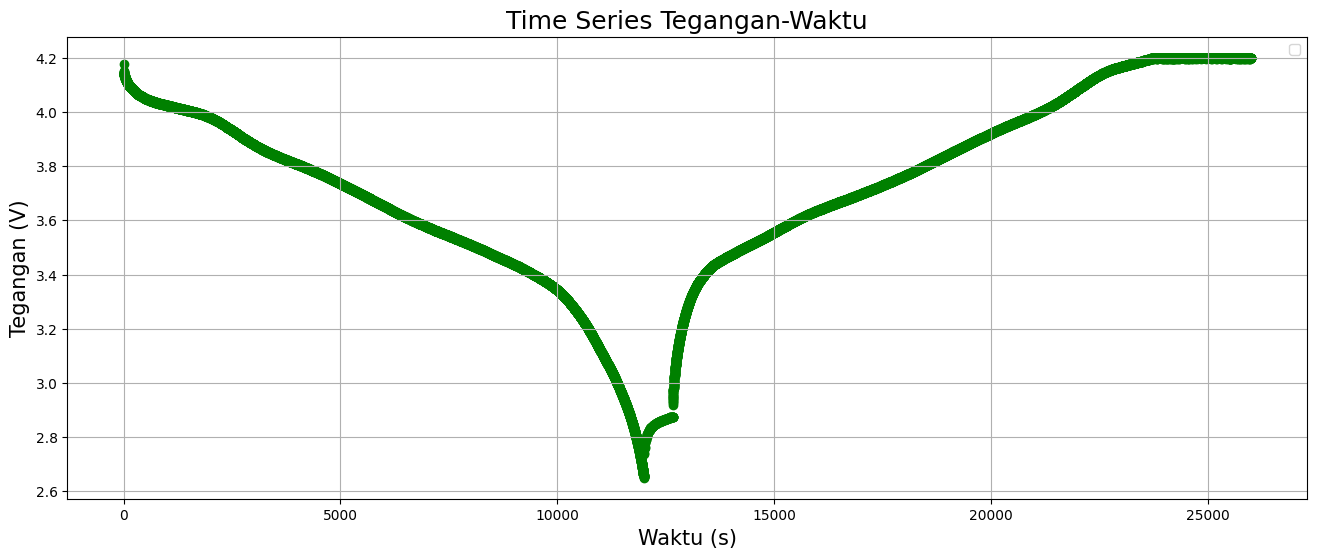

In [4]:
plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['Time (s)'], df['Voltage'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('Tegangan (V)', fontsize = 15)

plt.grid(True)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


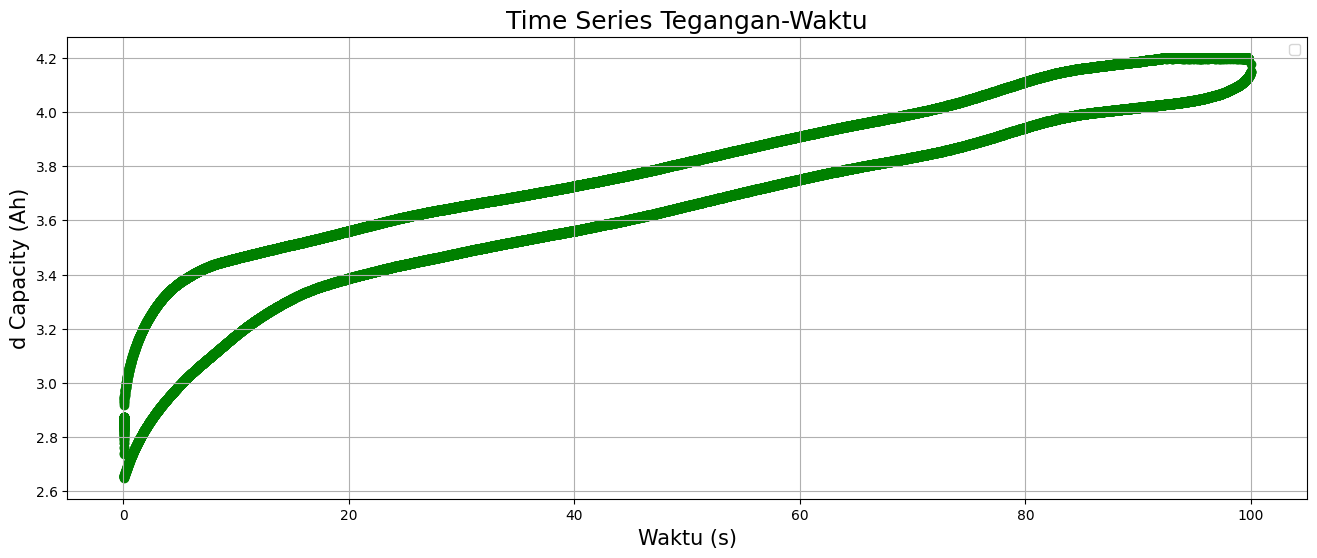

In [5]:
plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['SOCref'], df['Voltage'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('d Capacity (Ah)', fontsize = 15)

plt.grid(True)
plt.legend()

In [451]:
#df = pd.read_parquet('s1_training.parquet')

In [452]:
#df.head()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


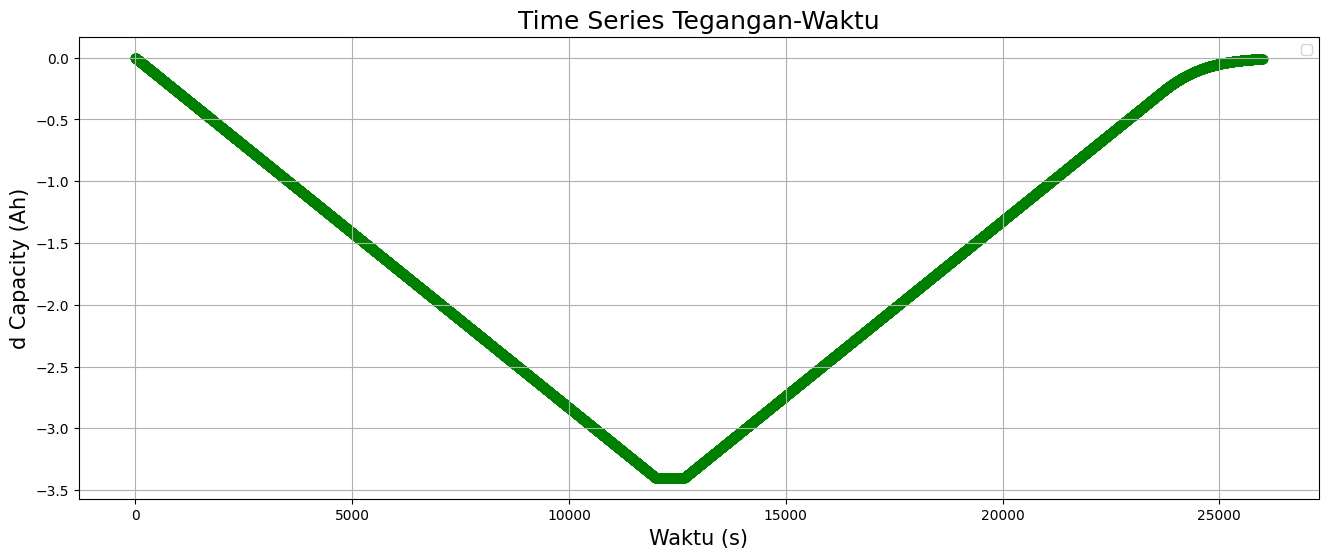

In [7]:
plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['Time (s)'], df['dCapacity_b'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('d Capacity (Ah)', fontsize = 15)

plt.grid(True)
plt.legend()

In [8]:
df.head()

Cycle                    Time  Time (s)  dTime   Voltage   Current   
0      1 2018-09-05 20:09:33.660      0.00   0.00  4.174988 -0.192759  \
1      1 2018-09-05 20:09:34.700      1.04   1.04  4.149462 -1.018668   
2      1 2018-09-05 20:09:35.670      2.01   0.97  4.147639 -1.022889   
3      1 2018-09-05 20:09:36.690      3.03   1.02  4.145816 -1.020075   
4      1 2018-09-05 20:09:37.680      4.02   0.99  4.145451 -1.020075   

   Temperature  dCapacity_a  dCapacity_b    deltaV       DOD      SOCref   
0         27.0    -0.000000    -0.000000  0.000000  0.000000  100.000000  \
1         27.0    -0.000294    -0.000294  0.025526  0.008655   99.991345   
2         27.0    -0.000276    -0.000570  0.001823  0.016762   99.983238   
3         27.0    -0.000289    -0.000859  0.001823  0.025262   99.974738   
4         27.0    -0.000281    -0.001139  0.000365  0.033513   99.966487   

        OCV   dEnergy  Energy (Wh)  
0  4.168242 -0.000000    -0.000000  
1  4.113809 -0.001221    -0.001221  
2  4.111838 -0.001143    -0.002364  
3  4.110113 -0.001198    -0.003562  
4  4.109748 -0.001163    -0.004725

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


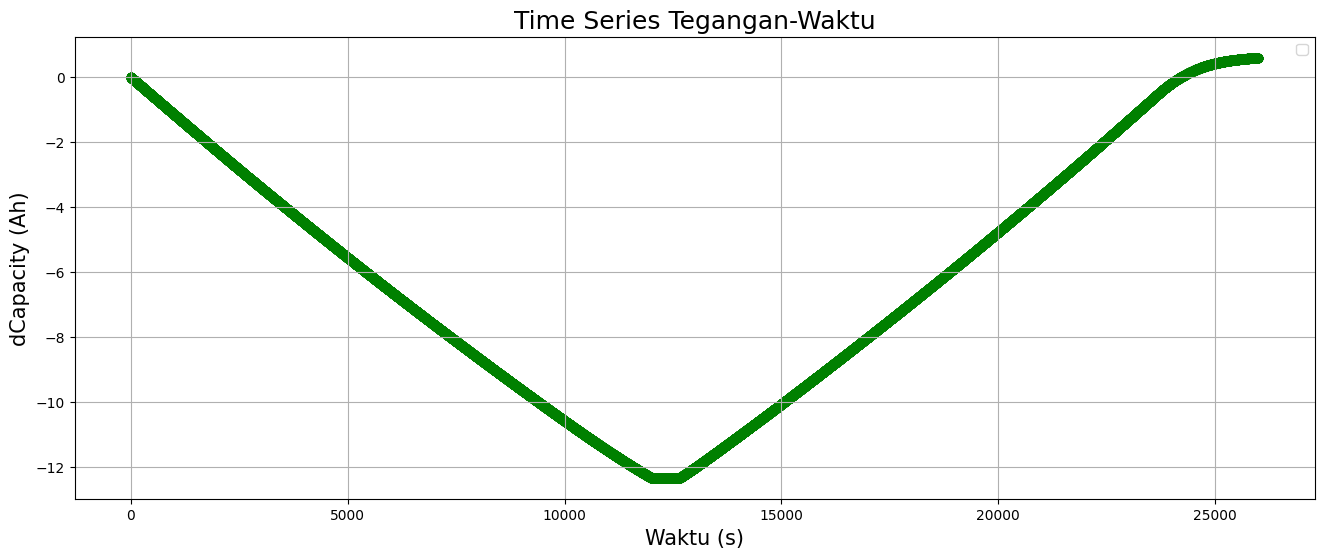

In [10]:
plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['Time (s)'], df['Energy (Wh)'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('dCapacity (Ah)', fontsize = 15)

plt.grid(True)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


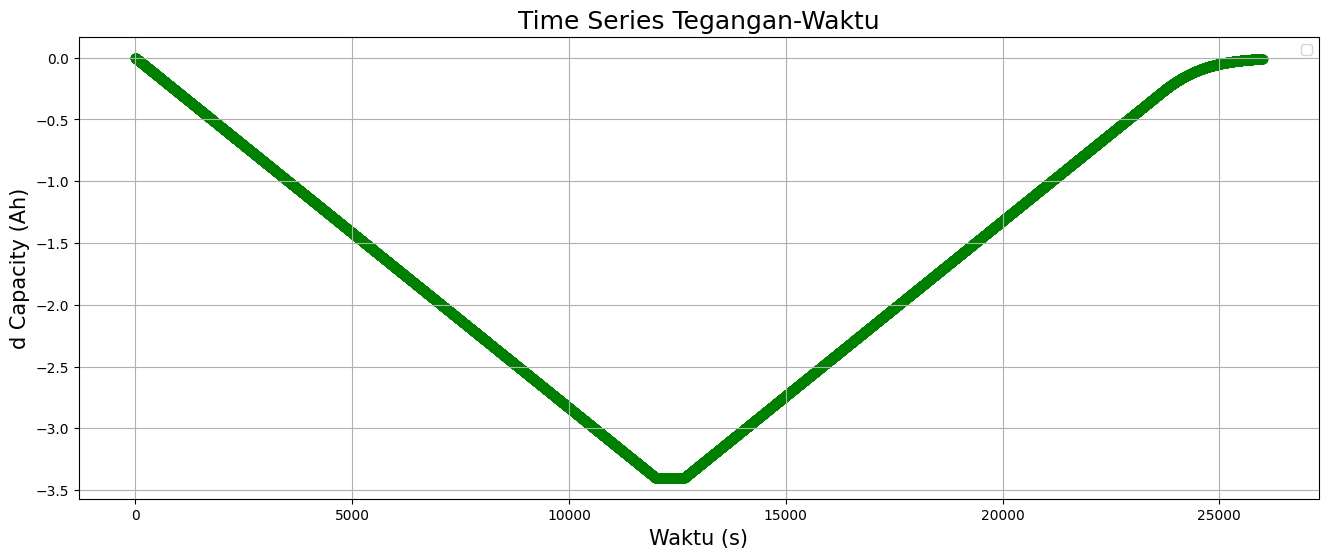

In [489]:
plt.figure(figsize = (16,6))
plt.title('Time Series Tegangan-Waktu', fontsize = 18)
plt.scatter(df['Time (s)'], df['dCapacity'], color="green")

plt.xlabel('Waktu (s)', fontsize = 15)
plt.ylabel('d Capacity (Ah)', fontsize = 15)

plt.grid(True)
plt.legend()

In [454]:
#df = pd.concat(
    #map(pd.read_parquet, ['s1_validasi.parquet', 's2_validasi.parquet']), ignore_index=True)
#print(df)

In [455]:
#df.to_csv('datavalidasi_2cyc_OCV.csv', index=False)
#df.to_parquet('datavalidasi_2cyc_OCV.parquet', index=False)

# Gabung Data Training 15 Siklus

In [2]:
df = pd.concat(
    map(pd.read_parquet, ['s1_training.parquet', 's2_training.parquet', 's3_training.parquet', 's4_training.parquet', 's5_training.parquet', 's6_training.parquet', 's7_training.parquet', 's8_training.parquet', 's9_training.parquet', 's10_training.parquet', 's11_training.parquet', 's12_training.parquet', 's13_training.parquet', 's14_training.parquet', 's15_training.parquet']), ignore_index=True)
print(df)

        Cycle                    Time  Time (s)  dTime   Voltage   Current   
0           1 2018-09-05 20:09:33.660      0.00   0.00  4.174988 -0.192759  \
1           1 2018-09-05 20:09:34.700      1.04   1.04  4.149462 -1.018668   
2           1 2018-09-05 20:09:35.670      2.01   0.97  4.147639 -1.022889   
3           1 2018-09-05 20:09:36.690      3.03   1.02  4.145816 -1.020075   
4           1 2018-09-05 20:09:37.680      4.02   0.99  4.145451 -1.020075   
...       ...                     ...       ...    ...       ...       ...   
372967     15 2019-01-15 11:46:37.630  22082.45   0.98  4.199117  1.020448   
372968     15 2019-01-15 11:46:38.660  22083.48   1.03  4.199482  1.019043   
372969     15 2019-01-15 11:46:39.270  22084.09   0.61  4.199847  1.020448   
372970     15 2019-01-15 11:46:39.630  22084.45   0.36  4.199482  1.019043   
372971     15 2019-01-15 11:46:39.840  22084.66   0.21  4.199847  1.020448   

        Temperature  dCapacity_a  dCapacity_b  discharge capaci

In [3]:
df.to_csv('datatraining_15cyc_OCV.csv', index=False)
df.to_parquet('datatraining_15cyc_OCV.parquet', index=False)

In [457]:
#df = df[['Cycle', 'Time', 'Time (s)', 'dTime','Voltage', 'Current', 'Temperature', 'dCapacity_a', 'dCapacity_b', 'deltaV', 'DOD', 'SOCref', 'OCV']]

In [458]:
#df.describe()

In [459]:
# Nilai OCV
'''Ri_chg = 0.018597224855098092
Ri_dschg = 0.23269098953

def calc_ocv(row):
    if row['Current'] < 0:
        return row['Voltage'] - row['Current']*Ri_dschg
    else:
        return row['Voltage'] + row['Current']*Ri_chg

df['OCV'] = df.apply(calc_ocv, axis=1)'''

"Ri_chg = 0.018597224855098092\nRi_dschg = 0.23269098953\n\ndef calc_ocv(row):\n    if row['Current'] < 0:\n        return row['Voltage'] - row['Current']*Ri_dschg\n    else:\n        return row['Voltage'] + row['Current']*Ri_chg\n\ndf['OCV'] = df.apply(calc_ocv, axis=1)"

In [460]:
#result = df.loc[df['SOCref'] < 0]
#print(result)

In [461]:
#result2 = df.loc[df['DOD'] > 100]
#print(result2)

In [462]:
#len(result)

In [463]:
#df.to_csv('datatraining_15cyc_OCV_SOCoutlier.csv', index=False)
#df.to_parquet('datatraining_15cyc_OCV_SOCoutlier.parquet', index=False)

# Bersih outlier pada SOC

In [464]:
#df = pd.read_parquet('datatraining_15cyc_OCV.parquet')

In [465]:
#df.head()

In [466]:
#df.drop(df[df['SOCref'] < 0].index, inplace=True)

In [467]:
#df.describe()

In [468]:
#df.to_parquet('datatraining_15cyc_OCV.parquet', index=False)
#df.to_csv('datatraining_15cyc_OCV.csv', index=False)

In [469]:
#df.to_parquet('dataunderstanding_15cyc_OCV.parquet', index=False)
#df.to_csv('dataunderstanding_15cyc_OCV.csv', index=False)